# Employment by sector and departement

In [1]:
from pynsee.localdata import get_local_metadata, get_nivgeo_list, get_local_data
from pynsee.geodata import get_geodata, GeoFrDataFrame
from pynsee.metadata import get_activity_list
from shapely import wkt

import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import math

from matplotlib.pyplot import pie
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# get a list all data available : datasets and variables
metadata = get_local_metadata()

# geographic metadata
nivgeo = get_nivgeo_list()

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get departement map
dep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')

dep = dep.transform_overseas(departement=['971', '972', '974', '973', '976'],
                   factor=[1.5, 1.5, 1.5, 0.3, 1.5])

dep = dep.zoom(factor = 3.5 , startAngle = math.pi * (1 - 3 * 1/9))

dep = dep[["code_insee", "geometry"]]
dep = dep.rename(columns={'code_insee': 'CODEGEO'})

In [3]:
# get local data from INSEE API
data = get_local_data(
    dataset_version='GEO2020FLORES2017', variables='NA17', nivgeo='DEP')

data = data.rename(columns={'NA17': 'A17'})

INSEE API credentials have not been found: please try to reuse pynsee.init_conn to save them locally.
Otherwise, you can still use environment variables as follow:

import os
os.environ['sirene_key'] = 'my_sirene_key'
Getting data: 100%|██████████| 101/101 [03:01<00:00,  1.80s/it]      


In [4]:
# keep only headcounts and remove the total from the data
df = data[data["UNIT"] == "NBSALET"].reset_index(drop=True)
df = df[~df["A17"].isin(["ENS"])].reset_index(drop=True)

In [5]:
# compute share of activity in total employment by department
df['employment_share'] = 100 * df["OBS_VALUE"] / df['OBS_VALUE'].groupby(df['CODEGEO']).transform('sum')

In [6]:
# merge values and geographic limits
datamap = GeoFrDataFrame(df.merge(dep, how = 'left', on = 'CODEGEO'))

In [7]:
# add english activity labels at A17 level
activity = get_activity_list("A17")
activity["TITLE_A17_EN"] = activity["A17"] + " - " + activity["TITLE_A17_EN"]
datamap = datamap.merge(activity, how='left', on='A17')

In [8]:
# compute center location for each departement
datamap["center"] = datamap.geometry.centroid

# list of departements
list_dep = datamap["CODEGEO"].unique()

In [9]:
# make color palette
colors = sns.color_palette("Set1") + sns.color_palette("Set2")

# order activity sectors according to average share
emplTot = datamap[["employment_share", "TITLE_A17_EN"]].groupby(['TITLE_A17_EN'], observed=True).mean()
emplTot = emplTot.sort_values(by=["employment_share"],  ascending=False)

datamap["TITLE_A17_EN"] = datamap["TITLE_A17_EN"].astype(CategoricalDtype(categories=emplTot.index, ordered=True))
datamap = datamap.sort_values(["TITLE_A17_EN"]).reset_index(drop=True)
datamap

,CODEGEO,NIVGEO,UNIT_label_fr,UNIT,A17,OBS_VALUE,NA17_label,DATASET_VERSION,DATASET_NAME,DATA_DATE,employment_share,geometry,A5,A10,TITLE_A17_EN,TITLE_A17_FR,center
0,24,DEP,Postes salariés dans les établissements,NBSALET,OQ,47091.0,Activité économique en 17 postes (NA - A17),GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017.0,39.785237,"MULTIPOLYGON (((27120.328 5599468.283, 27106.6...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (82503.91 5638329.284)
1,33,DEP,Postes salariés dans les établissements,NBSALET,OQ,199158.0,Activité économique en 17 postes (NA - A17),GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017.0,32.943017,"MULTIPOLYGON (((-139393.72 5554680.837, -13928...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-64234.389 5594353.684)
2,71,DEP,Postes salariés dans les établissements,NBSALET,OQ,61315.0,Activité économique en 17 postes (NA - A17),GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017.0,34.317841,"MULTIPOLYGON (((548723.5 5861512.99, 548643.52...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (505726.208 5884496.126)
3,01,DEP,Postes salariés dans les établissements,NBSALET,OQ,54202.0,Activité économique en 17 postes (NA - A17),GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017.0,29.047782,"MULTIPOLYGON (((533898.382 5802670.867, 534054...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (595403.95 5796511.951)
4,22,DEP,Postes salariés dans les établissements,NBSALET,OQ,66843.0,Activité économique en 17 postes (NA - A17),GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017.0,36.247933,"MULTIPOLYGON (((-400990.704 6236235.694, -4009...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-318975.243 6180666.226)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,13,DEP,Postes salariés dans les établissements,NBSALET,C2,1446.0,Activité économique en 17 postes (NA - A17),GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017.0,0.182878,"MULTIPOLYGON (((582085.39 5342294.655, 582092....",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (566101.71 5395492.184)
1764,26,DEP,Postes salariés dans les établissements,NBSALET,C2,0.0,Activité économique en 17 postes (NA - A17),GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017.0,0.000000,"MULTIPOLYGON (((559856.744 5511665.293, 559637...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (575197.887 5572442.063)
1765,59,DEP,Postes salariés dans les établissements,NBSALET,C2,269.0,Activité économique en 17 postes (NA - A17),GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017.0,0.027313,"MULTIPOLYGON (((336295.261 6472777.256, 336428...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (357475.652 6524772.888)
1766,27,DEP,Postes salariés dans les établissements,NBSALET,C2,0.0,Activité économique en 17 postes (NA - A17),GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017.0,0.000000,"MULTIPOLYGON (((74664.181 6343633.985, 75574.8...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (110910.519 6294369.44)


In [10]:
emplTot

,employment_share
TITLE_A17_EN,
"OQ - Public administration and defence, education, human health and social work activities",36.017645
GZ - Wholesale and retail trade; repair of motor vehicles and motorcycles,13.797260
"MN - Professional, scientific, technical, administrative and support service activities",9.349464
C5 - Other manufacturing,6.822302
FZ - Construction,6.040776
HZ - Transportation and storage,5.366087
IZ - Accommodation and food service activities,4.072490
RU - Other services activities,3.733203
"C1 - Manufacture of food products, beverages and tobacco products",3.016751


In [11]:
# draw plot

def extract_lon(x):
    return wkt.loads(x).xy[0][0]
def extract_lat(x):
    return wkt.loads(x).xy[1][0]

ax = datamap.plot(color='white', edgecolor='black', figsize = (15,15))

ax_sub_coeff = 80000

for idep in list_dep:
    
    df = datamap[datamap["CODEGEO"] == idep].reset_index(drop=True)
    df["lon"] = df["center"].apply(lambda p: p.x)
    df["lat"] = df["center"].apply(lambda p: p.y)

    df = df[df["lon"] == min(df["lon"])].reset_index(drop=True)
    center = df.loc[0,"lon"], df.loc[0,"lat"]

    ratios = df["employment_share"]

    ax_sub = ax.inset_axes(
                    bounds=(center[0]-ax_sub_coeff/2,
                            center[1]-ax_sub_coeff/2, 
                            ax_sub_coeff, ax_sub_coeff),
                    transform=ax.transData
                   )
    
    ax_sub.pie(ratios, wedgeprops={'edgecolor': 'gray','linewidth': 0.25}, colors = colors)
    

plt.suptitle('Employment by sector and departement', x = 0.4, y = 0.85,
            horizontalalignment= 'left',
            fontsize = 12, fontweight='bold')
plt.legend(emplTot.index, loc="lower left", bbox_to_anchor=(-27, -9), ncol=2)
plt.savefig('empl_map_fr.png')
plt.close()

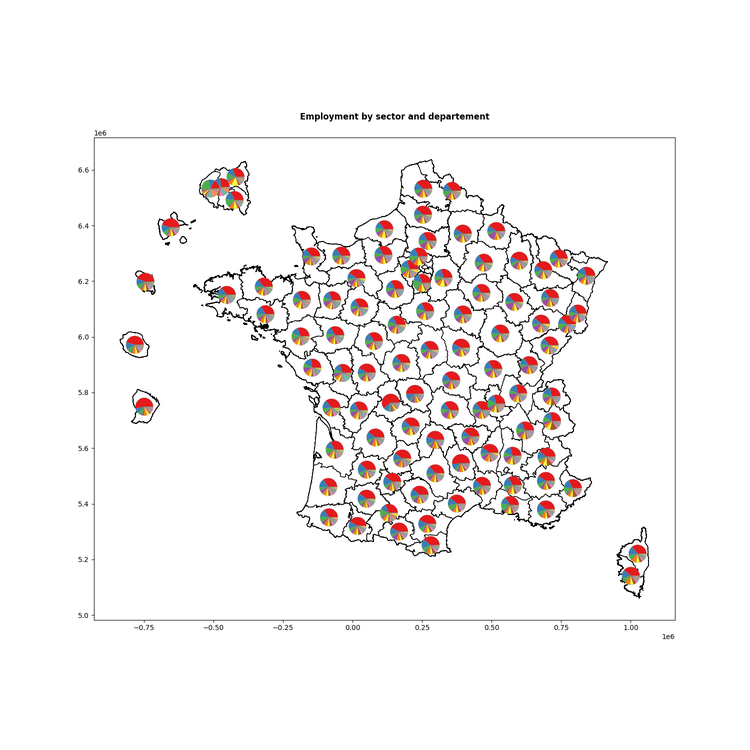

In [12]:
from PIL import Image 
def resize_pix(img, pct):
    hsize = int((float(img.size[1])*float(pct)))
    wsize = int((float(img.size[0])*float(pct)))
    img = img.resize((wsize,hsize), Image.Resampling.LANCZOS)
    return img
    
img = Image.open('empl_map_fr.png').convert("RGB")
img = resize_pix(img, pct=0.5)
img